# MRI Tumor Detection
## To predict whether tumor exists or not in MRI images with ResNet50.

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)    
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [77]:
brain_df = pd.read_csv('./Brain_MRI/data_mask.csv')  # data refers to kaggle
display(brain_df.head(5))
print(brain_df.shape)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


(3929, 4)


In [78]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

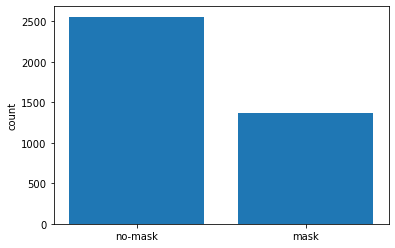

In [83]:
# import plotly.graph_objects as go
# fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts(),width=[0.5,0.5])])
# fig.show()
plt.bar(['no-mask', 'mask'], [np.sum(brain_df['mask'] == 0), np.sum(brain_df['mask'] != 0)])
plt.ylabel('count')
plt.show()

Text(0.5, 1, 'Distribution of patient_id and mask(diagnosis)')

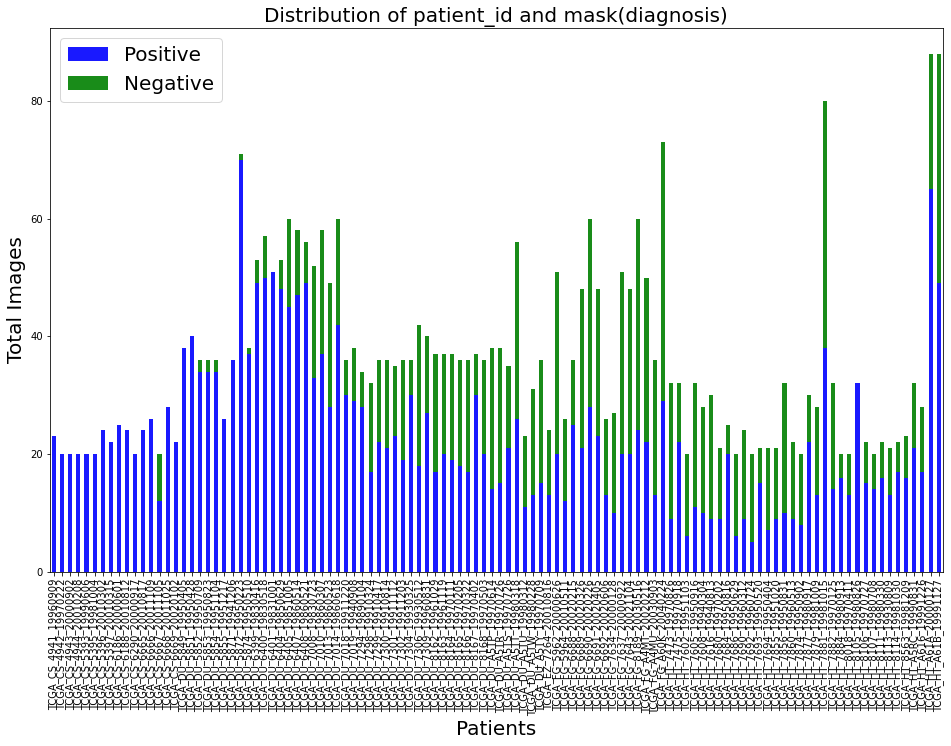

In [31]:
# Plot
patients_by_diagnosis = brain_df.groupby(['patient_id', 'mask'])['mask'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]
ax = patients_by_diagnosis.plot(kind='bar',stacked=True, figsize=(16, 10),color=["blue", "green"],alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of patient_id and mask(diagnosis)",fontsize = 20, y=1)

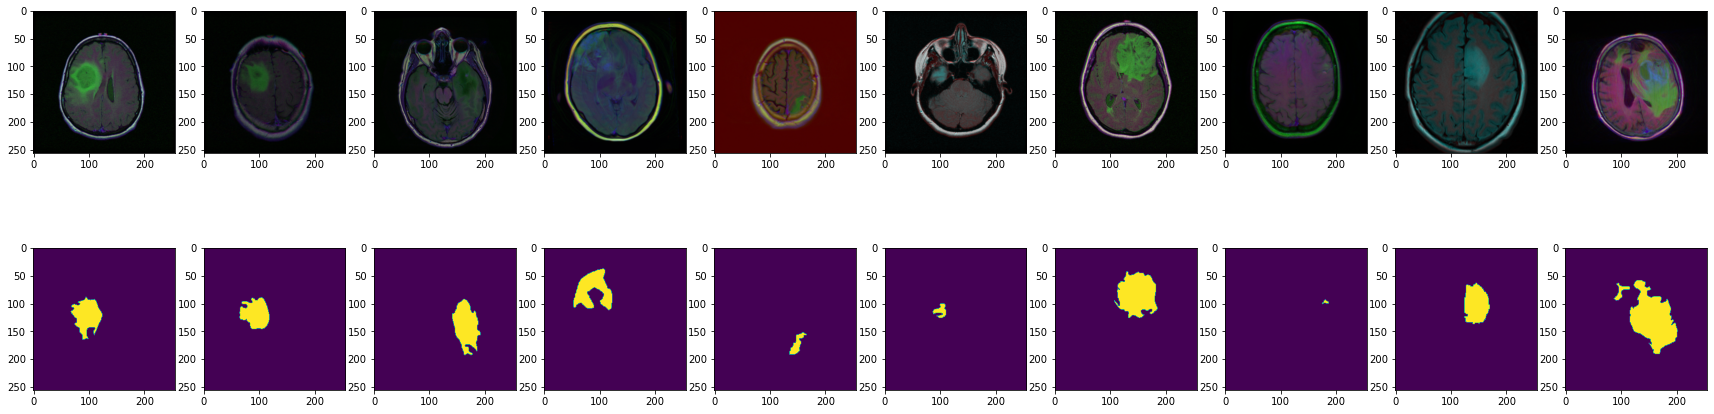

In [75]:
# Find 10 images having mask (ONLY)
from PIL import Image
idxs = []
while len(idxs) < 10:
    idx = random.randint(0, len(brain_df) - 1)
    if brain_df.iloc[idx]['mask'] > 0:
        idxs.append(idx)
path_img_rgb = []
path_img_mask = []
mask = []
plt.figure(figsize=(30,8))
for i, idx in enumerate(idxs):        
    img_rgb = Image.open(path + brain_df.iloc[idx]['image_path'])
    img_mask = Image.open(path + brain_df.iloc[idx]['mask_path'])    
    plt.subplot(2, 10, i + 1)
    plt.imshow(img_rgb)    
    plt.subplot(2, 10, (i + 1) + 10)
    plt.imshow(img_mask)    
    path_img_rgb.append(brain_df.iloc[idx]['image_path'])
    path_img_mask.append(brain_df.iloc[idx]['mask_path'])
    mask.append(brain_df.iloc[idx]['mask'])
plt.show()

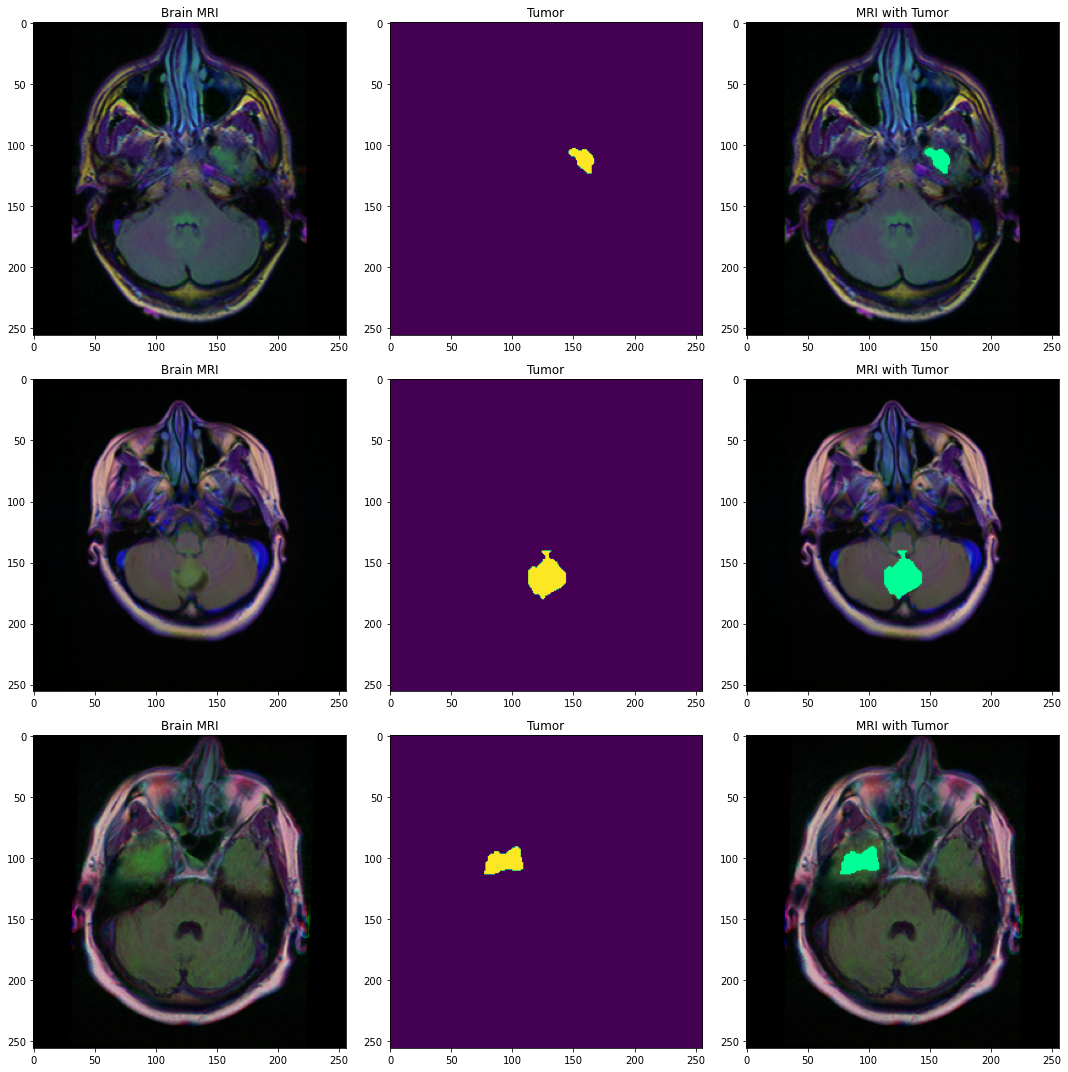

In [32]:
# Only show MRIs of patients with tumor (zoom in for more details)
path = './Brain_MRI/'
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(15,15))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(path + brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)        
        mask = io.imread(path + brain_df.mask_path[i])
        axs[count][1].title.set_text("Tumor")
        axs[count][1].imshow(mask)        
        img[mask==255] = (0,255,150) 
        axs[count][2].title.set_text("MRI with Tumor")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break        
fig.tight_layout()

In [33]:
# Drop patient id column, Convert column mask to string as categorical.
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
print(brain_df.shape)
brain_df.head(5)

(3929, 4)


,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [35]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size=0.15)
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)
train_generator = datagen.flow_from_dataframe(train, directory=path, x_col='image_path', y_col='mask', subset='training',
                                              class_mode='categorical', batch_size=10, shuffle=True, target_size=(256,256))
valid_generator = datagen.flow_from_dataframe(train, directory=path,x_col='image_path', y_col='mask', subset='validation',
                                              class_mode='categorical', batch_size=10, shuffle=True, target_size=(256,256))
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test, directory=path, x_col='image_path', y_col='mask', 
                                                  class_mode='categorical', batch_size=10, shuffle=False, target_size=(256,256))

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


## ResNet50

In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [40]:
base = clf_model.output
base = AveragePooling2D(pool_size=(4,4))(base)
base = Flatten(name='Flatten')(base)
base = Dense(256, activation='relu')(base)
base = Dropout(0.3)(base)
base = Dense(256, activation='relu')(base)
base = Dropout(0.3)(base)
base = Dense(2, activation='softmax')(base)
model = Model(clf_model.input, base)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [41]:
h = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // train_generator.batch_size, epochs = 20, 
              validation_data= valid_generator, validation_steps= valid_generator.n // valid_generator.batch_size)

Epoch 1/20
300/300 [==============================] - 36s 121ms/step - loss: 0.3212 - accuracy: 0.8872 - val_loss: 3.4481 - val_accuracy: 0.7758
Epoch 2/20
300/300 [==============================] - 36s 119ms/step - loss: 0.2564 - accuracy: 0.9035 - val_loss: 0.6381 - val_accuracy: 0.8909
Epoch 3/20
300/300 [==============================] - 36s 121ms/step - loss: 0.2106 - accuracy: 0.9282 - val_loss: 0.2784 - val_accuracy: 0.9273
Epoch 4/20
300/300 [==============================] - 36s 120ms/step - loss: 0.1736 - accuracy: 0.9366 - val_loss: 0.4268 - val_accuracy: 0.8788
Epoch 5/20
300/300 [==============================] - 36s 121ms/step - loss: 0.1810 - accuracy: 0.9379 - val_loss: 0.1268 - val_accuracy: 0.9727
Epoch 6/20
300/300 [==============================] - 36s 120ms/step - loss: 0.1275 - accuracy: 0.9496 - val_loss: 0.2219 - val_accuracy: 0.9364
Epoch 7/20
300/300 [==============================] - 36s 121ms/step - loss: 0.1435 - accuracy: 0.9486 - val_loss: 0.2127 - val_ac

In [44]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

37/37 [==============================] - 2s 51ms/step - loss: 0.3149 - accuracy: 0.9508
Test accuracy : 95.08474469184875 %


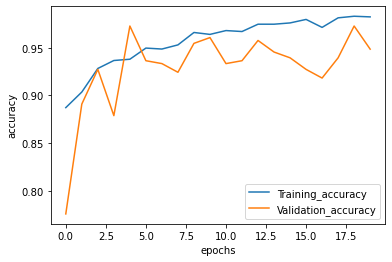

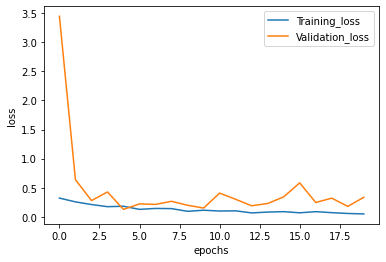

In [49]:
# plot the training loss and accuracy
def acc_loss_plot(H):
# plot the training loss and accuracy
    accs = H.history['accuracy']
    val_accs = H.history['val_accuracy']
    
    plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
    plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()
    
    loss = H.history['loss']
    val_loss = H.history['val_loss']

    plt.plot(range(len(accs)),loss, label = 'Training_loss')
    plt.plot(range(len(accs)),val_loss, label = 'Validation_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()        
acc_loss_plot(h)

0.9508474576271186
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       377
           1       0.96      0.91      0.93       213

    accuracy                           0.95       590
   macro avg       0.95      0.94      0.95       590
weighted avg       0.95      0.95      0.95       590



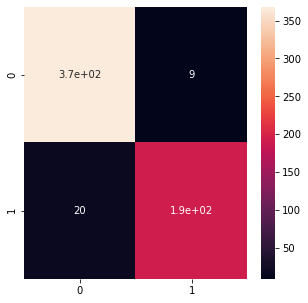

In [46]:
prediction = model.predict(test_generator)
pred = np.argmax(prediction, axis=1)
original = np.asarray(test['mask']).astype('int')
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
cm = confusion_matrix(original, pred)
report = classification_report(original, pred, labels = [0,1])
print(accuracy)
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);